<a href="https://colab.research.google.com/github/1Un/MNIST/blob/master/16x_cnn_mnist_lenet5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](https://engmrk.com/wp-content/uploads/2018/09/LeNet_Original_Image.jpg)

![alt text](https://engmrk.com/wp-content/uploads/2018/09/LeNEt_Summary_Table.jpg)

In [0]:
import torch
import random
import numpy as np

# random.seed(0)
# np.random.seed(0)
# torch.manual_seed(0)
# torch.cuda.manual_seed(0)
# torch.backends.cudnn.deterministic = True

In [0]:
import torchvision.datasets

In [3]:
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


In [4]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [5]:
len(y_train), len(y_test)

(60000, 10000)

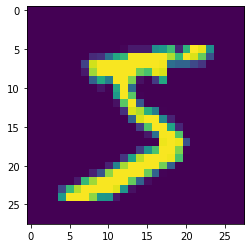

tensor(5)


In [6]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

In [7]:
X_train.shape


torch.Size([60000, 28, 28])

In [0]:
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [9]:
X_train.shape
# отличие от полносвязанной сети, которая видела картинку как один вектор длинный,
# мы хотим в конволюционную сеть передавать картинку как трёхмерный тензор.
# Первый канал -- это глубина картинки, в черно-белой картинке это 1
# канал с яркостью серого пикселя. А в RGB картинке будут RGB каналы.
# Соответственно, мы должны нашу картинку, которая на вход пришла (она просто "28 на 28"),
# разжать до "1 на 28 на 28". Вот мы это и делаем -- мы делаем X_train.unsqueeze,
# а здесь ставим индекс: "а в каком же измерении мы хотим разжать".
# То есть X_train у нас -- тензор из 60 000 картинок 28 на 28,
# а мы хотим чтобы было 60 000 на 1 на 28 на 28, и то же самое мы делаем с тестом.

torch.Size([60000, 1, 28, 28])

In [0]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        #conv 2d называется так как матрица у нас двумерная  
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1  = torch.nn.Tanh()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
       
        self.conv2 = torch.nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.act2  = torch.nn.Tanh()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        
        #изображение в 1 вектор растянем в forward а пока в конструкторе прдеставим что это уже сделано
        self.fc1   = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3  = torch.nn.Tanh()
        
        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.Tanh()
        
        self.fc3   = torch.nn.Linear(84, 10)
    
    #x - входной тензор, т.е. батч из картинок 
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        #преобразуем наш тенхор к нужной размерности x.size(0) - размер батча 
        #а дальше тензор одномерный очевидно что бы получить этот размер надо
        #просто перемножить 3 размерности
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x
    


In [11]:
# def sum_par(model):
#   s=0
#   for i in model.parameters():
#     #print(i)
#     print(len(i.reshape(-1)))
#     s+=len(i.reshape(-1))
#   return s
# print('sum=',sum_par(lenet5))
lenet5= LeNet5()
import torchsummary
print("Все параметры сети:")
torchsummary.summary(lenet5.cuda(),(1,28,28))
#(1,28,28) - размер входного изображения 
def study(lenet5,X_test,y_test,X_train,y_train,batch_size = 100):  
  #!nvidia-smi
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  lenet5 = lenet5.to(device)
  loss = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)
  

  test_accuracy_history = []
  test_loss_history = []

  X_test = X_test.to(device)
  y_test = y_test.to(device)

  for epoch in range(100):
      order = np.random.permutation(len(X_train))
      for start_index in range(0, len(X_train), batch_size):
          optimizer.zero_grad()
          
          batch_indexes = order[start_index:start_index+batch_size]
          
          X_batch = X_train[batch_indexes].to(device)
          y_batch = y_train[batch_indexes].to(device)
          
          preds = lenet5.forward(X_batch) 
          
          loss_value = loss(preds, y_batch)
          loss_value.backward()
          
          optimizer.step()
          
      test_preds = lenet5.forward(X_test)
      test_loss_history.append(loss(test_preds, y_test).data.cpu())

      accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
      test_accuracy_history.append(accuracy)

      if epoch%10==0:
        print('epoch=',epoch,'\taccuracy=',accuracy)
  return test_loss_history,test_accuracy_history
      

Все параметры сети:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
              Tanh-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              Tanh-5           [-1, 16, 10, 10]               0
         AvgPool2d-6             [-1, 16, 5, 5]               0
            Linear-7                  [-1, 120]          48,120
              Tanh-8                  [-1, 120]               0
            Linear-9                   [-1, 84]          10,164
             Tanh-10                   [-1, 84]               0
           Linear-11                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (

In [12]:
test_loss_history=[]
test_accuracy_history=[]
!nvidia-smi

Sat Apr 25 20:20:51 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    27W /  70W |    805MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [13]:
for i in range(16):
  print('=====',i,'=====')
  test_loss_history1,test_accuracy_history1=study(lenet5,X_test,y_test,X_train,y_train,batch_size = 100)
  test_loss_history.append(test_loss_history1)
  test_accuracy_history.append(test_accuracy_history1)

===== 0 =====
epoch= 0 	accuracy= tensor(0.9782)
epoch= 10 	accuracy= tensor(0.9869)
epoch= 20 	accuracy= tensor(0.9867)
epoch= 30 	accuracy= tensor(0.9879)
epoch= 40 	accuracy= tensor(0.9890)
epoch= 50 	accuracy= tensor(0.9876)
epoch= 60 	accuracy= tensor(0.9876)
epoch= 70 	accuracy= tensor(0.9894)
epoch= 80 	accuracy= tensor(0.9900)
epoch= 90 	accuracy= tensor(0.9902)
===== 1 =====
epoch= 0 	accuracy= tensor(0.9886)
epoch= 10 	accuracy= tensor(0.9873)
epoch= 20 	accuracy= tensor(0.9878)
epoch= 30 	accuracy= tensor(0.9884)
epoch= 40 	accuracy= tensor(0.9888)
epoch= 50 	accuracy= tensor(0.9875)
epoch= 60 	accuracy= tensor(0.9856)
epoch= 70 	accuracy= tensor(0.9868)
epoch= 80 	accuracy= tensor(0.9890)
epoch= 90 	accuracy= tensor(0.9898)
===== 2 =====
epoch= 0 	accuracy= tensor(0.9873)
epoch= 10 	accuracy= tensor(0.9897)
epoch= 20 	accuracy= tensor(0.9879)
epoch= 30 	accuracy= tensor(0.9891)
epoch= 40 	accuracy= tensor(0.9873)
epoch= 50 	accuracy= tensor(0.9895)
epoch= 60 	accuracy= tens

In [0]:
import pandas as pd
import numpy as np

In [0]:
test_loss_history_np=np.array(test_loss_history)
test_accuracy_history_np=np.array(test_accuracy_history)

In [18]:
#показание лосс функции на последней эпохе
x=np.copy(test_loss_history_np)
y=np.copy(test_accuracy_history_np)
print(test_loss_history_np[:,-1])

[0.07380131 0.07097014 0.05927046 0.09077706 0.08714703 0.09196741
 0.09015215 0.09289087 0.08844602 0.075818   0.09212382 0.08947682
 0.08598679 0.0889051  0.09172964 0.1048371 ]


In [19]:
#точность предсказания на последней эпохе 
print(test_accuracy_history_np[:,-1])   

[0.9899     0.988      0.99009997 0.9888     0.98749995 0.98789996
 0.98829997 0.9877     0.988      0.98929995 0.98859996 0.98969996
 0.9881     0.9891     0.98939997 0.98679996]


максимальная точность на последнй эпохе обучения  0.99009997 
этот результат получили на попытке обучения № 2
минимальная точность  на последнй эпохе обучения 0.98679996 
этот результат получили на попытке обучения № 15
Разность=0.0033000112


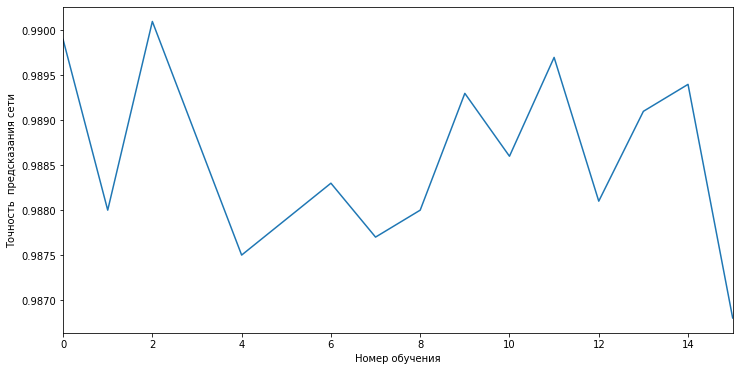

In [45]:

fig, ax = plt.subplots(figsize=(12,6))
ax.set_xlim([0, 15])

ax.plot(np.array(range(len(test_accuracy_history_np[:,-1]))),test_accuracy_history_np[:,-1])  


ax.set_xlabel('Номер обучения')

ax.set_ylabel('Точность  предсказания сети')

plt.savefig('2.svg')
print('максимальная точность на последнй эпохе обучения ',test_accuracy_history_np[:,-1].max(),
      '\nэтот результат получили на попытке обучения №',test_accuracy_history_np[:,-1].argmax())  
print('минимальная точность  на последнй эпохе обучения',test_accuracy_history_np[:,-1].min(),
      '\nэтот результат получили на попытке обучения №',test_accuracy_history_np[:,-1].argmin())
print('Разность=',test_accuracy_history_np[:,-1].max()-test_accuracy_history_np[:,-1].min(),sep='')

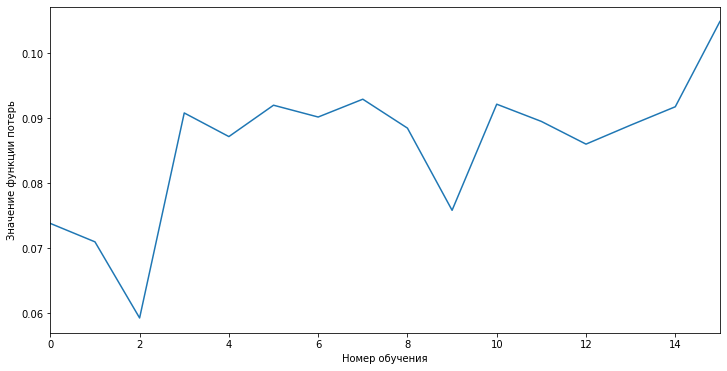

максимальное значение функции потерь на последней эпохе обучения  0.1048371 
этот результат получили на попытке обучения № 15
минимальная точность  на последнй эпохе обучения 0.05927046 
этот результат получили на попытке обучения № 2
Разность=0.045566637


In [46]:

fig, ax = plt.subplots(figsize=(12,6))
ax.set_xlim([0, 15])

ax.plot(np.array(range(len(test_loss_history_np[:,-1]))),test_loss_history_np[:,-1])  


ax.set_xlabel('Номер обучения')

ax.set_ylabel('Значение функции потерь')

plt.savefig('3.png')
plt.show()
print('максимальное значение функции потерь на последней эпохе обучения ',test_loss_history_np[:,-1].max(),
      '\nэтот результат получили на попытке обучения №',test_loss_history_np[:,-1].argmax())  
print('минимальная точность  на последнй эпохе обучения',test_loss_history_np[:,-1].min(),
      '\nэтот результат получили на попытке обучения №',test_loss_history_np[:,-1].argmin())

print('Разность=',test_loss_history_np[:,-1].max()-test_loss_history_np[:,-1].min(),sep='')

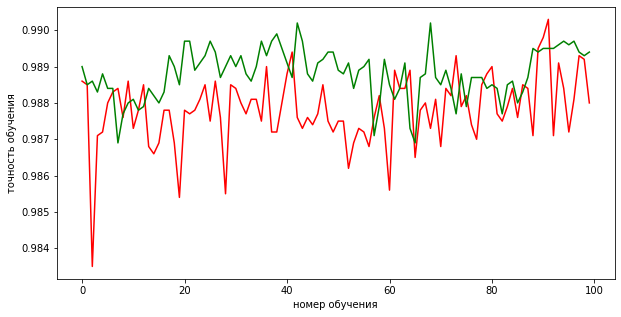

Красная линия - максимальная точность
Зеленая линия - минимальная точность


In [47]:
#вывдем графики точности с максимальной и минимальной тосность(accuracy) предсказания
plt.figure(figsize=(10,5))
plt.plot(test_accuracy_history_np[1],'r',test_accuracy_history_np[14],'g')  
plt.xlabel('номер обучения')
plt.ylabel('точность обучения')
plt.show()
print('Красная линия - максимальная точность\nЗеленая линия - минимальная точность')

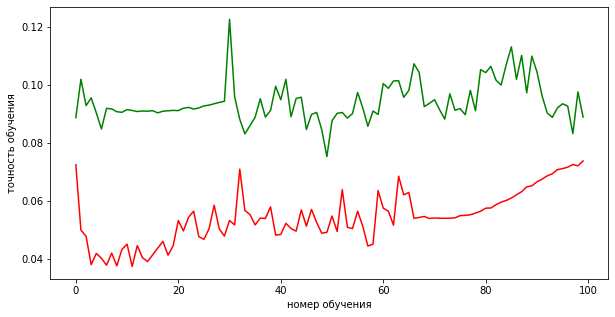

Красная линия - весь график(все эпохи) с максимальное значение функции потерь на последней эпохе обучения 
Зеленая линия - минимальная точность  на последнй эпохе обучения


In [48]:
plt.figure(figsize=(10,5))
plt.plot(test_loss_history_np[0],'r',test_loss_history_np[13],'g')   
plt.xlabel('номер обучения')
plt.ylabel('точность обучения')
plt.show()
print('Красная линия - весь график(все эпохи) с максимальное значение функции потерь на последней эпохе обучения',
      '\nЗеленая линия - минимальная точность  на последнй эпохе обучения')

In [0]:
# save numpy array as csv file
from numpy import asarray
from numpy import savetxt
# define data
# save to csv file
savetxt('26test_loss_history_np.csv', test_loss_history_np, delimiter=',')
savetxt('26test_accuracy_history_np.csv', test_accuracy_history_np, delimiter=',')
